# Payload-Range diagram

This section describes how to create a simple payload-range diagram for the example airplane. This diagram should be created towards the end of conceptual design i.e. after performing trade studies and other major design activities such as weight and balance, and stability. The quantities like maximum takeoff weight and maximum fuel tank capacity should be known to create this diagram. There are four points that essentially define the diagram:

**Point A**: This point refers to a scenario where the airplane is at maximum payload but has zero cruise range. It defines the point on the y-axis since the range is zero. Note that this point is available since the maximum payload is known.

**Point B**: This point denotes the mission for which airplane is sized i.e. airplane is fully loaded and contains fuel for flying the design mission. This point is known from the design mission.

**Point C**: At this point, the fuel tanks are completely filled. Hence, the payload weight has to be reduced so that the total weight is still equal to the maximum takeoff weight. Note that the fuel for design mission will be less than the maximum capacity of the fuel tanks. 

**Point D**: Finally, this point refers to ferry range i.e. the distane flown by the airplane when it is carrying maximum fuel and no passengers.

Only point C and D are unknown. The first step is to compute the maximum fuel tank capacity. This is already computed within `AircraftParamters` class. This will yield the fuel weight for point C and D, and is used to determine the decrease in payload at point C. Then, a nonlinear equation is solved numerically to find the cruise range of the airplane for a given takeoff weight and fuel weight. Once these four points are known, final step is to plot them.

> __NOTE__: For any point on the payload-range diagram, the range should be computed while accounting for the reserve mission. Also, any cruise requirement, such as speed or time, should be met.

Below code block imports required libraries and defines a function for computing the fuel weight for a given airplane parameters, takeoff weight, and cruise range. This function is coupled with a nonlinear solver to determine a value of cruise range so that fuel weight returned by this method is same as the fuel weight at Point C or D.

In [11]:
import nbimporter
import matplotlib.pyplot as plt
from parameters import AircraftParameters
from fuel import compute_cruise_weight_fraction, compute_loiter_weight_fraction
from scipy.optimize import fsolve

# from trade studies
A = 9
S = 138 # sq ft
takeoff_power = 719 # hp
MTOW = 6258 # lbs
fuel_weight = 1620 # lbs

# other parameters
max_payload = 1000 # lbs does not include crew
x0 = 1000 * 6076.11549 # ft, starting value of range while solve nonlinear eqn

# Initialize parameter class
aircraft = AircraftParameters(A, S, takeoff_power)

def compute_fuel_weight(parameters: AircraftParameters, weight, cruise_range):
    """
        Method to compute fuel weight for a given maximum takeoff weight to
        complete the mission profile, inlcludng the reserver mission.

        Parameters
        ---------
        parameters: 
            AircraftParameters object that defines various aircraft parameters

        weight: float
            maximum takeoff weight for which mission fuel needs to be comptued, lbs

        cruise_range: float
            the range for which airplane will be cruising, ft


        Returns
        -------
        fuel_weight: float
            the fuel weight required for given takeoff weight and cruise range
    """

    W0 = weight
    W1_W0 = parameters.W1_W0
    W2_W1 = parameters.W2_W1
    W4_W3 = parameters.W4_W3

    # Compute cruise weight fraction
    weight = W2_W1 * W1_W0 * weight # weight at the start of cruise
    W3_W2, avg_cruise_power, avg_cruise_CL = compute_cruise_weight_fraction(parameters, weight, cruise_range, parameters.cruise_speed, num_segements=1000)
    parameters.W3_W2 = W3_W2
    parameters.avg_cruise_power = avg_cruise_power
    parameters.avg_cruise_CL = avg_cruise_CL

    # Compute loiter weight fraction
    W5_W4 = parameters.W5_W4
    weight = W5_W4 * W4_W3 * W3_W2 * weight # weight at the start of loiter
    W6_W5, avg_loiter_power, avg_loiter_speed = compute_loiter_weight_fraction(parameters, weight, parameters.endurance, num_segements=1000)
    parameters.W6_W5 = W6_W5
    parameters.avg_loiter_power = avg_loiter_power
    parameters.avg_loiter_speed = avg_loiter_speed

    W7_W6 = parameters.W7_W6
    W8_W7 = parameters.W8_W7

    # compute final weight fraction
    W8_W0 = W8_W7 * W7_W6 * W6_W5 * W5_W4 * W4_W3 * W3_W2 * W2_W1 * W1_W0 # mission weight fraction
    Wf_W0 = 1.06 * (1 - W8_W0) # 6% is for trapped unusable fuel

    parameters.fuel_weight = Wf_W0 * W0
    
    return parameters.fuel_weight # fuel weight

# Equation which needs to be solved to find the range for a given fuel weight
eqn = lambda x, takeoff_weight, fuel: compute_fuel_weight(aircraft, takeoff_weight, x[0]) - fuel

## Point B

Below code block computes the range at Point B i.e. airplane is at maixmum takeoff weight with fuel to fly the design mission (including reserves). Even though the range is known at Point B, the range is computed to validate that the nonlinear solver. The calculated range should be same as the design range.

In [6]:
range_pointB = fsolve(eqn, x0=x0, args=(MTOW, fuel_weight)).item()/6076.11549 # nmi

print(f"Range at point B: {range_pointB:.0f} nmi")

Range at point B: 1200 nmi


Based on the above calculation, the cruise range is same as the design mission range which validates the code.

## Point C

Below code block computes the range at Point C:

In [7]:
max_fuel_weight = aircraft.fuel_tank_volume * aircraft.avgas_density # lbs
payload_pointC = max_payload - (max_fuel_weight - fuel_weight)

range_pointC = fsolve(eqn, x0=x0, args=(MTOW, max_fuel_weight)).item()/6076.11549 # nmi

print(f"Range at point B: {range_pointC:.0f} nmi")

Range at point B: 1223 nmi


## Point D

Below code block computes the range at Point D:

In [8]:
takeoff_weight = MTOW - payload_pointC

range_pointD = fsolve(eqn, x0=x0, args=(takeoff_weight, max_fuel_weight)).item()/6076.11549 # nmi

print(f"Range at point D: {range_pointD:.0f} nmi")

Range at point D: 1374 nmi


## Final plot

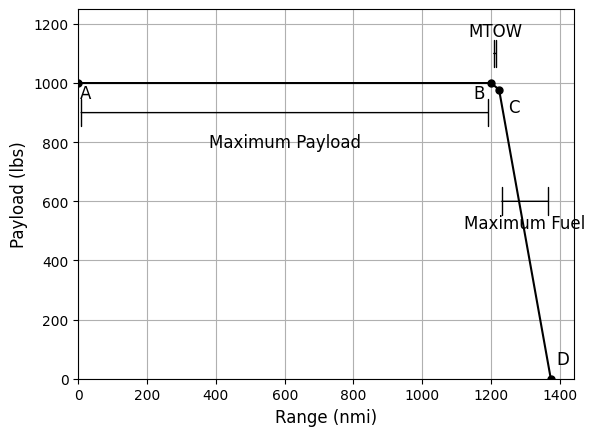

In [9]:
payload = [max_payload, max_payload, payload_pointC, 0.0]
range = [0, range_pointB, range_pointC, range_pointD]
fs = 12

fig, ax = plt.subplots()
ax.plot(range, payload, "k", marker="o", markersize=5)
ax.grid()
ax.set_xlabel("Range (nmi)", fontsize=fs)
ax.set_ylabel("Payload (lbs)", fontsize=fs)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0, top=1250)

ax.annotate("A", (5,950), fontsize=fs)
ax.annotate("B", (1150,950), fontsize=fs)
ax.annotate("C", (1250,900), fontsize=fs)
ax.annotate("D", (1390,50), fontsize=fs)

plt.annotate('', xy=(0,max_payload-100), xytext=(range_pointB,max_payload-100), arrowprops=dict(arrowstyle='|-|'), alpha=0.75)
plt.annotate('', xy=(range_pointB, max_payload+100), xytext=(range_pointC, max_payload+100), arrowprops=dict(arrowstyle='|-|'), alpha=0.75)
plt.annotate('', xy=(range_pointC, max_payload-400), xytext=(range_pointD, max_payload-400), arrowprops=dict(arrowstyle='|-|'), alpha=0.75)

ax.annotate("Maximum Payload", (range_pointB/2, max_payload/1.25), fontsize=fs, ha="center", va="center")
ax.annotate("MTOW", ((range_pointB+range_pointC)/2, max_payload/0.85), fontsize=fs, ha="center", va="center")
_ = ax.annotate("Maximum Fuel", ((range_pointC+range_pointD)/2, max_payload/1.9), fontsize=fs, ha="center", va="center")

> __NOTE__: The Point B and C are close since the fuel weight for design mission is comparable to the maximum fuel that the tanks can hold. Refer to [aspect ratio trade study](ar_study.ipynb) for more details. The wing fuel volume is one of the driving constraints for the design.

This concludes the payload-range diagram section.